In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

### Part 2: Exploratory Data Analysis
Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:  
    a. How often does the candidate who raised more money win a race?  
    b. How often does the candidate who spent more money win a race?  
    c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?  
    d. How often does the incumbent candidate win a race?  
    e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [3]:
os.chdir('..')
print(f'current working directory is {os.getcwd()}')

current working directory is C:\Users\lexil\Documents\NSS_Projects\open-secrets-three-musketeers


In [4]:
full_df = pd.read_csv('../open-secrets-three-musketeers/data/full_df.csv')

In [5]:
df_dropped_columns = full_df.drop(columns=['Incumbent', 'IncCID', 'capeye', 'SmLgIndivsNote', 'DistIDCurr', 'PACs', 'Indivs', 'Cand', 'Other', 'ReleaseDate', 'enddate'])

In [6]:
df_clean = df_dropped_columns.rename(columns={'Rcpts': 'Money_Raised', 'Spent': 'Money_Spent'})

How often does the candidate who raised more money win a race?

would we loop through wins over losses in a specific district and then calculate the probability?

In [8]:
df_clean['Result'] = df_clean['Result'].replace(r'^\s*$', np.nan, regex=True)
df_clean.dropna()

,cid,FirstLastP,Money_Raised,Money_Spent,EndCash,LgIndivs,SmIndivs,VotePercent,Result,CRPICO,State,primarydate,sort,District,State_Abv
0,N00044245,Jerry Carl (R),1971321.50,1859348.91,111972.59,999616.34,44579.61,64.88,W,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
1,N00044750,James Averhart (D),80094.95,78973.24,1121.71,37954.77,12895.18,35.04,L,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
2,N00041295,Barry Moore (R),650806.75,669367.70,-13633.28,346328.65,62207.55,65.30,W,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
3,N00045944,Phyllis Harvey-Hall (D),56049.68,55988.07,0.00,27105.15,15306.80,34.61,L,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
5,N00024759,Mike D Rogers (R),1193111.43,1218563.76,502233.70,438054.00,5315.00,67.54,W,I,Alabama,2020-03-03 00:00:00 +0000,1,3,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,N00045620,Tricia Zunker (D),1261957.30,1232690.26,29267.04,566859.76,600014.91,39.24,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,7,WI
1257,N00039330,Mike Gallagher (R),3202904.74,2841800.71,1169361.53,2040298.63,188430.08,63.98,W,I,Wisconsin,2020-08-11 00:00:00 +0000,1,8,WI
1258,N00045078,Amanda Stuck (D),416978.45,399915.94,2164.80,221453.03,169379.57,36.02,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,8,WI
1259,N00035504,Liz Cheney (R),3003883.34,3060166.78,153567.15,980348.72,189646.74,68.60,W,I,Wyoming,2020-08-18 00:00:00 +0000,1,1,WY


In [9]:
df_clean['Result'] = df_clean['Result'].replace('l', 'L').replace('w', 'W')

a. How often does the candidate who raised more money win a race?

In [11]:
candidate_win_raised_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Raised'].max()
        losers_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Raised'].max()
        if winners_top_rcpts > max(0, losers_top_rcpts): #losers_top_rcpts can be nan, replace with 0
            candidate_win_raised_count += 1
candidate_win_raised_percentage = 100 * candidate_win_raised_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_raised_percentage

89.14549653579677

b. How often does the candidate who spent more money win a race?

In [13]:
candidate_win_spent_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Spent'].max()
        losers_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Spent'].max()
        if winners_top_spent > max(0, losers_top_spent): #losers_top_spent can be nan, replace with 0
            candidate_win_spent_count += 1
candidate_win_spent_percentage = 100 * candidate_win_spent_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_spent_percentage

88.45265588914549

GROUPED BAR CHART Wins (money spent/money spent - MAYBE

In [14]:
df_grouped = df_clean.groupby('Result')[['Money_Spent', 'Money_Raised']].sum().reset_index()

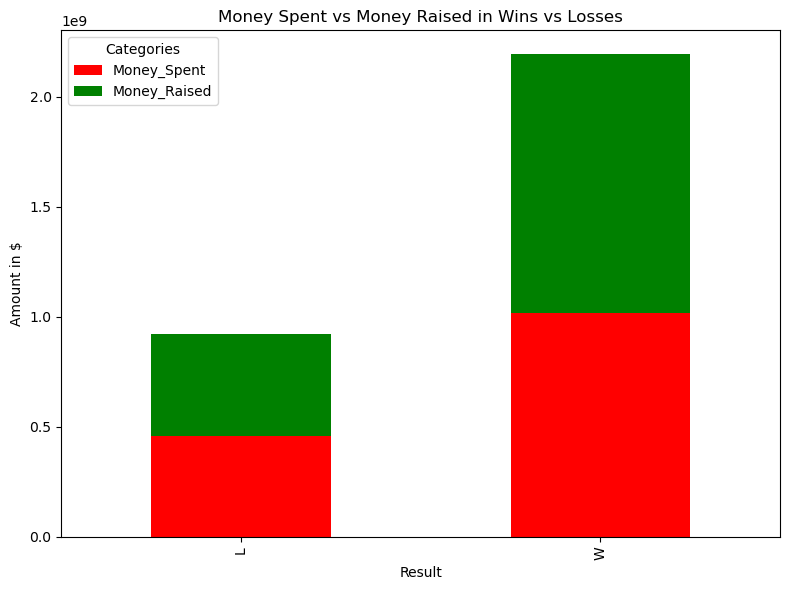

In [15]:
df_grouped.set_index('Result', inplace=True)

ax = df_grouped.plot(kind='bar', stacked=True, figsize=(8, 6), color=['red', 'green'])

ax.set_ylabel('Amount in $')
ax.set_title('Money Spent vs Money Raised in Wins vs Losses')
ax.set_xlabel('Result')

ax.legend(title="Categories", loc='upper left')

plt.tight_layout()
plt.show()